In [89]:
from bs4 import BeautifulSoup
from IPython.display import HTML

import requests
import concurrent.futures

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tqdm

from typing import List, NamedTuple, Union, Callable, Tuple
from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In [7]:
url = "https://mobile-legends.fandom.com/wiki/List_of_heroes"    # Edit this with your selected URL
text = requests.get(url).text                                    # This will get the HTML source

soup = BeautifulSoup(text, 'html5lib')                           # Parse the HTML source into soup object

In [8]:
print(soup.prettify()[:])

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of heroes | Mobile Legends: Bang Bang Wiki | Fandom
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"857045968cc3c6d","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_heroes","wgTitle":"List of heroes","wgCurRevisionId":144911,"wgRevisionId":144911,"wgArticleId":14076,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Pages with broken file links","Heroes","Shop"],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgRelevantPageName":"Lis

## Get the column names 

In [10]:
table = soup.find("table")

column_name = []
for th in table.find_all("th"):
  column_name.append(th.text.strip())

column_name

['Hero',
 'Name',
 'Hero Code',
 'Role(s)',
 'Specialties',
 'Laning',
 'Release Year',
 'Price']

## Get all the rows

In [11]:
rows = []

for idx_row, tr in enumerate(table.find_all("tr")[1:]):    # Skip the first row because it is the header
  row_data = {}
  all_td = tr.find_all("td")
  row_data["name"]          = all_td[1].text.strip()
  
  ## Get the url page for hero
  row_data["hero_url_page"] = "/".join(url.split("/")[:-1] + [row_data["name"]])

  row_data["hero_code"]     = all_td[2].text.strip()
  row_data["role"]          = all_td[3].text.strip()
  row_data["specialties"]   = all_td[4].text.strip()
  row_data["laning"]        = all_td[5].text.strip()
  row_data["release_year"]  = all_td[6].text.strip()


  ## Special handling for price column
  price = all_td[7]
  try:
    row_data["price"] = " | ".join([a_tag["title"] 
                                      for a_tag in price.find_all("a")])
  except (KeyError):
    print(f"specific parsing; idx_row: {idx_row}; hero_name: {row_data['name']}") 
    price_unit = price.find_all("img")[0]["alt"]
    row_data["price"] = price.text.strip() + " " + price_unit

  rows.append(row_data)

rows

specific parsing; idx_row: 45; hero_name: Odette


[{'name': 'Miya',
  'hero_url_page': 'https://mobile-legends.fandom.com/wiki/Miya',
  'hero_code': '1',
  'role': 'Marksman',
  'specialties': 'Reap | Damage',
  'laning': 'Gold Laner',
  'release_year': '2016',
  'price': '10800 Battle Points | 399 ticket'},
 {'name': 'Balmond',
  'hero_url_page': 'https://mobile-legends.fandom.com/wiki/Balmond',
  'hero_code': '2',
  'role': 'Fighter',
  'specialties': 'Damage | Regen',
  'laning': 'EXP Laner',
  'release_year': '2016',
  'price': '6500 Battle Points | 299 diamonds'},
 {'name': 'Saber',
  'hero_url_page': 'https://mobile-legends.fandom.com/wiki/Saber',
  'hero_code': '3',
  'role': 'Assassin',
  'specialties': 'Charge | Reap',
  'laning': 'Jungler',
  'release_year': '2016',
  'price': '6500 Battle Points | 299 diamonds'},
 {'name': 'Alice',
  'hero_url_page': 'https://mobile-legends.fandom.com/wiki/Alice',
  'hero_code': '4',
  'role': 'Mage |  Tank',
  'specialties': 'Charge | Regen',
  'laning': 'Mid Laner',
  'release_year': '201

Exploration detail to get url for hero

In [12]:
tr2 = table.find_all("tr")[2]
tr2_colURL = "/".join(url.split("/")[:-1] 
                        +  [tr2.find_all("td")[1].text.strip()])
tr2_colURL

'https://mobile-legends.fandom.com/wiki/Balmond'

Exploration detail to get the code for extracting price column 

In [13]:
tr2 = table.find_all("tr")[2]    # Skip the first row because it is the header
tr2_colPrice = tr2.find_all("td")[7]
tr2_colPrice = " | ".join([a_tag["title"] for a_tag in tr2_colPrice.find_all("a")])
tr2_colPrice

'6500 Battle Points | 299 diamonds'

Exploration detail to handle specific format in row 45+1 (plus header), and price column

In [14]:
tr45 = table.find_all("tr")[46]
tr45_colPrice = tr45.find_all("td")[7]
tr45_colPrice_unit = tr45_colPrice.find_all("img")[0]["alt"]
tr45_colPrice = tr45_colPrice.text.strip() + " " + tr45_colPrice_unit
tr45_colPrice 

'20 Lucky Gem'

## Turn into DataFrame

In [15]:
df_heroes = pd.DataFrame(rows)
df_heroes

,name,hero_url_page,hero_code,role,specialties,laning,release_year,price
0,Miya,https://mobile-legends.fandom.com/wiki/Miya,1,Marksman,Reap | Damage,Gold Laner,2016,10800 Battle Points | 399 ticket
1,Balmond,https://mobile-legends.fandom.com/wiki/Balmond,2,Fighter,Damage | Regen,EXP Laner,2016,6500 Battle Points | 299 diamonds
2,Saber,https://mobile-legends.fandom.com/wiki/Saber,3,Assassin,Charge | Reap,Jungler,2016,6500 Battle Points | 299 diamonds
3,Alice,https://mobile-legends.fandom.com/wiki/Alice,4,Mage | Tank,Charge | Regen,Mid Laner,2016,15000 Battle Points | 399 diamonds
4,Nana,https://mobile-legends.fandom.com/wiki/Nana,5,Mage,Poke | Burst,Mid Laner,2016,6500 Battle Points | 299 diamonds
...,...,...,...,...,...,...,...,...
116,Fredrinn,https://mobile-legends.fandom.com/wiki/Fredrinn,117,Tank | Fighter,Damage | Chase,EXP Laner,2022,32000 Battle Points | 599 diamonds
117,Joy,https://mobile-legends.fandom.com/wiki/Joy,118,Assassin,Chase | Damage,EXP Laner,2022,32000 Battle Points | 599 diamonds
118,Novaria,https://mobile-legends.fandom.com/wiki/Novaria,119,Mage,Burst | Poke,Mid Laner,,32000 Battle Points | 599 diamonds
119,Arlott,https://mobile-legends.fandom.com/wiki/Arlott,120,Fighter,Charge | Burst,EXP Laner,,32000 Battle Points | 599 diamonds


## Get statistics of specific Herro

In [85]:
def get_hero_by_name(df, name):
  row = df.loc[df["name"] == name]

  url = row["hero_url_page"].values[0]
  text = requests.get(url).text
  soup = BeautifulSoup(text, 'html5lib')
  return soup 


def get_attributes(hero_soup, verbose=False):
  try:
    attributes = hero_soup.find("span", {"id": "Attributes"})\
                    .find_parent("h2").find_next("table")
  except (AttributeError):
    attributes = hero_soup.find(string="Attributes")
    attributes = attributes.find_parent("table")
    # print(attributes)

    all_tr = attributes.find_all("tr")
    # print(all_tr)

    all_text = [tag.text.strip() for tag in all_tr]
    print(all_text)
    return [False, 'HTML format is different from the Fandom standard table']

  if verbose:
    display(attributes)
  
  rows = []
  
  # cleaning empty row:  <tr class="mw-empty-elt">
  all_tr = attributes.find_all("tr")
  all_tr = [tr for tr in all_tr if not tr.has_attr("class")]
  # display(all_tr)


  for tr in all_tr[2:]:      # skip the first two rows
    row_data = {}
    all_td = tr.find_all("td")
    row_data["attribute"] = all_td[0].text.strip()
    
    # If there is no change during the level progression, set it to the 
    # same as base_lvl_01.
    row_data["base_lvl_01"] = all_td[1].text.strip()
    row_data["base_lvl_15"] = all_td[2].text.strip() \
      if len(all_td) == 4 else all_td[1].text.strip()


    rows.append(row_data)
  
  return rows

In [72]:
pick_hero = "Kadita"    # This page does not meet Fandom standard
# pick_hero = "Natalia"
# pick_hero = "Balmond"
hero_soup = get_hero_by_name(df_heroes, pick_hero)

### Some rules related to attributes

- All units have no base and extra magic power, but it can be increased     
  through talents, equipment, and hero skills
- Physical penetration, Magic penetration start at 0 but can be obtained     
  through emblems, items or even her abilities

In [86]:
get_attributes(hero_soup, verbose=False)
  

['Attributes', '● HP2491\n\n● Mana495', '● HP Regen7.2\n\n● Mana  Regen18', '● Physical Attack105\n\n● Magic Power0', '● Physical Defense18\n\n● Magic Defense15', '● Attack Speed1\n\n● Movement SPD240', '● Attack Speed100%']


[False, 'HTML format is different from the Fandom standard table']

## Get attributes for all possible scraped-data of heroes

In [40]:
def load_url(url, timeout):
  with requests.get(url, timeout=timeout) as response:
    return response


def fetch_all(URLS, num_of_workers=10):
  hero_names = [url.split("/")[-1] for url in URLS]

  hero_attributes = {}

  with concurrent.futures.ThreadPoolExecutor(max_workers=num_of_workers) as executor:
    future_to_url = {
      executor.submit(load_url, url, 60): [url, hero_name]
        for url, hero_name in zip(URLS, hero_names)}
    for future in concurrent.futures.as_completed(future_to_url):
      url, hero_name = future_to_url[future]
      try:
        data = future.result()
        hero_attributes[hero_name] = data.text
      except Exception as exc:
        print(f"{url} generated an exception: {exc}")
      else:
        print(f"{url} page has status_code: {data.status_code}")
  
  # To do concurrently for BeautifulSoup, you have to redefine
  # all the functions to be a Future object. For now, we 
  # parse one-by-one
  for key, val in hero_attributes.items():
    hero_soup = BeautifulSoup(val, 'html5lib')
    
    try:
      hero_attributes[key] = get_attributes(hero_soup)
    except (IndexError):
      hero_attributes[key] = "set_new_parsing_method"
      print("key:", key)

  return hero_attributes

In [41]:
hero_urls = df_heroes["hero_url_page"].to_list()
hero_urls_selected = hero_urls[:]
hero_urls_selected

['https://mobile-legends.fandom.com/wiki/Miya',
 'https://mobile-legends.fandom.com/wiki/Balmond',
 'https://mobile-legends.fandom.com/wiki/Saber',
 'https://mobile-legends.fandom.com/wiki/Alice',
 'https://mobile-legends.fandom.com/wiki/Nana',
 'https://mobile-legends.fandom.com/wiki/Tigreal',
 'https://mobile-legends.fandom.com/wiki/Alucard',
 'https://mobile-legends.fandom.com/wiki/Karina',
 'https://mobile-legends.fandom.com/wiki/Akai',
 'https://mobile-legends.fandom.com/wiki/Franco',
 'https://mobile-legends.fandom.com/wiki/Bane',
 'https://mobile-legends.fandom.com/wiki/Bruno',
 'https://mobile-legends.fandom.com/wiki/Clint',
 'https://mobile-legends.fandom.com/wiki/Rafaela',
 'https://mobile-legends.fandom.com/wiki/Eudora',
 'https://mobile-legends.fandom.com/wiki/Zilong',
 'https://mobile-legends.fandom.com/wiki/Fanny',
 'https://mobile-legends.fandom.com/wiki/Layla',
 'https://mobile-legends.fandom.com/wiki/Minotaur',
 'https://mobile-legends.fandom.com/wiki/Lolita',
 'https:

In [42]:
num_of_workers = 200
selected_hero_attrs = fetch_all(hero_urls_selected, 
                                num_of_workers=num_of_workers)
selected_hero_attrs

https://mobile-legends.fandom.com/wiki/Nana page has status_code: 200
https://mobile-legends.fandom.com/wiki/Minotaur page has status_code: 200
https://mobile-legends.fandom.com/wiki/Lolita page has status_code: 200
https://mobile-legends.fandom.com/wiki/Alice page has status_code: 200
https://mobile-legends.fandom.com/wiki/Alucard page has status_code: 200
https://mobile-legends.fandom.com/wiki/Alpha page has status_code: 200
https://mobile-legends.fandom.com/wiki/Chou page has status_code: 200
https://mobile-legends.fandom.com/wiki/Fanny page has status_code: 200
https://mobile-legends.fandom.com/wiki/Cyclops page has status_code: 200
https://mobile-legends.fandom.com/wiki/Kagura page has status_code: 200
https://mobile-legends.fandom.com/wiki/Gord page has status_code: 200
https://mobile-legends.fandom.com/wiki/Tigreal page has status_code: 200
https://mobile-legends.fandom.com/wiki/Bane page has status_code: 200
https://mobile-legends.fandom.com/wiki/Clint page has status_code: 200

{'Nana': [{'attribute': 'HP', 'base_lvl_01': '2501', 'base_lvl_15': '4321'},
  {'attribute': 'Mana', 'base_lvl_01': '510', 'base_lvl_15': '2050'},
  {'attribute': 'HP Regen', 'base_lvl_01': '6.8', 'base_lvl_15': '11.0'},
  {'attribute': 'Mana Regen', 'base_lvl_01': '3.6', 'base_lvl_15': '6.4'},
  {'attribute': 'Physical Attack', 'base_lvl_01': '115', 'base_lvl_15': '217'},
  {'attribute': 'Magic Power', 'base_lvl_01': '0', 'base_lvl_15': '0'},
  {'attribute': 'Physical Defense', 'base_lvl_01': '17', 'base_lvl_15': '59'},
  {'attribute': 'Magic Defense', 'base_lvl_01': '15', 'base_lvl_15': '38'},
  {'attribute': 'Physical Penetration',
   'base_lvl_01': '0',
   'base_lvl_15': '0'},
  {'attribute': 'Magic Penetration', 'base_lvl_01': '0', 'base_lvl_15': '0'},
  {'attribute': 'Damage Reduction', 'base_lvl_01': '0', 'base_lvl_15': '0'},
  {'attribute': 'Attack Speed', 'base_lvl_01': '1.08', 'base_lvl_15': '1.43'},
  {'attribute': 'Attack Speed Ratio',
   'base_lvl_01': '100%',
   'base_lvl

In [45]:
with open("./hero_attributes.json", "w") as file:
  json.dump(selected_hero_attrs, file)

## Load JSON file

In [47]:
# Opening JSON file
opened_file = open('./20230603_hero_attributes.json')
  
# returns JSON object as 
# a dictionary
data = json.load(opened_file)
data

{'Nana': [{'attribute': 'HP', 'base_lvl_01': '2501', 'base_lvl_15': '4321'},
  {'attribute': 'Mana', 'base_lvl_01': '510', 'base_lvl_15': '2050'},
  {'attribute': 'HP Regen', 'base_lvl_01': '6.8', 'base_lvl_15': '11.0'},
  {'attribute': 'Mana Regen', 'base_lvl_01': '3.6', 'base_lvl_15': '6.4'},
  {'attribute': 'Physical Attack', 'base_lvl_01': '115', 'base_lvl_15': '217'},
  {'attribute': 'Magic Power', 'base_lvl_01': '0', 'base_lvl_15': '0'},
  {'attribute': 'Physical Defense', 'base_lvl_01': '17', 'base_lvl_15': '59'},
  {'attribute': 'Magic Defense', 'base_lvl_01': '15', 'base_lvl_15': '38'},
  {'attribute': 'Physical Penetration',
   'base_lvl_01': '0',
   'base_lvl_15': '0'},
  {'attribute': 'Magic Penetration', 'base_lvl_01': '0', 'base_lvl_15': '0'},
  {'attribute': 'Damage Reduction', 'base_lvl_01': '0', 'base_lvl_15': '0'},
  {'attribute': 'Attack Speed', 'base_lvl_01': '1.08', 'base_lvl_15': '1.43'},
  {'attribute': 'Attack Speed Ratio',
   'base_lvl_01': '100%',
   'base_lvl

## Pre-processing for clustering

In [69]:
lvl1_hp_all_heroes = []
lvl1_phys_atk_all_heroes = []
list_hero_names = []

for k in data.keys():
  # -- get hp 
  try: 
    hp = data[k][0]['base_lvl_01'] 
    hp = int(hp)
  except (TypeError, ValueError):
    hp = 0

  # -- get physical attack (basic attack)
  try:
    phys_atk = data[k][4]['base_lvl_01']
    phys_atk = int(phys_atk)
  except (IndexError, ValueError):
    phys_atk = 0


  list_hero_names.append(k)
  lvl1_hp_all_heroes.append(hp)
  lvl1_phys_atk_all_heroes.append(phys_atk)


# lvl1_hp_all_heroes
# lvl1_phys_atk_all

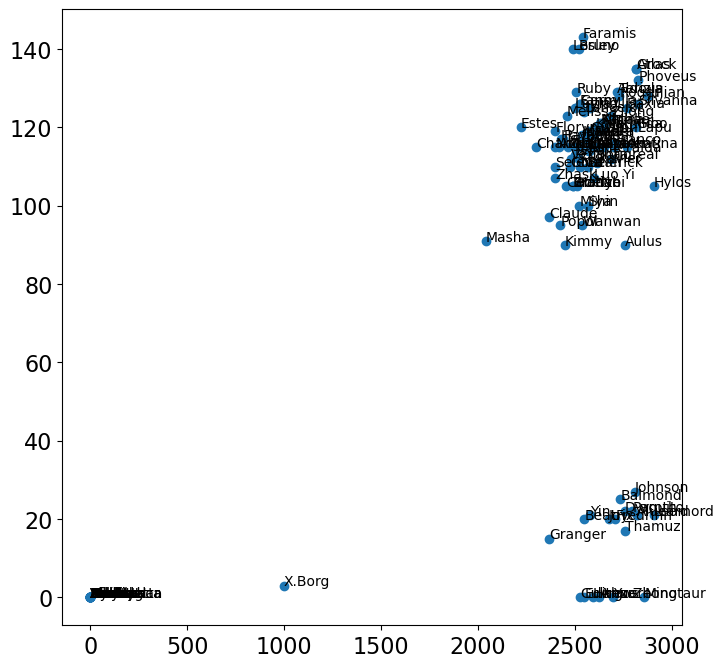

In [71]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(lvl1_hp_all_heroes, lvl1_phys_atk_all_heroes, marker='o', linestyle="None")

for idx, hero_name in enumerate(list_hero_names):
  ax.annotate(hero_name, (lvl1_hp_all_heroes[idx], lvl1_phys_atk_all_heroes[idx]), 
              fontsize=10)

plt.show(fig)

## Clustering

In [90]:
def num_differences(v1: Vector, v2: Vector, tol: float = 1e-5) -> int:
  assert len(v1) == len(v2)
  return len([x1 for x1, x2 in zip(v1, v2) if abs(x1-x2) > tol])

In [91]:
def cluster_means(k: int, inputs: List[Vector], 
                  assignments: List[int], 
                  rng) -> List[Vector]:

  # clusters[i] contains the inputs whose assignment is i
  clusters = [[] for i in range(k)]
  for input, assignment in zip(inputs, assignments):
    clusters[assignment].append(input)

  # if a cluster is empty, just use a random point
  return [la.vector_mean(cluster) if cluster else rng.choice(inputs)
          for cluster in clusters]

In [92]:
class KMeans(object):
  def __init__(self, k: int) -> None:
    self.k = k            # number of clusters
    self.means = None
    self.means_init = None

  def classify(self, input: Vector) -> int:
    """return the index of the cluster closest to the input"""
    return min(range(self.k), 
      key=lambda i: la.squared_distance(input, self.means[i]))

  def train(self, inputs: List[Vector], seed: int = 2023_04_27) -> None:
    # Start with random assignments
    rng = np.random.default_rng(seed)
    assignments = [rng.integers(self.k) for _ in inputs]

    with tqdm.tqdm(itertools.count()) as t:
      for _ in t:
        # Compute means and find new assignments
        self.means = cluster_means(self.k, inputs, assignments, rng)
        if _ == 0:
          self.means_init = self.means

        new_assignments = [self.classify(input) for input in inputs]

        # Check how many assignments changed and if we're done
        num_changed = num_differences(assignments, new_assignments)
        if num_changed == 0:
          return

        # Otherwise keep the new assignments, and compute new means
        assignments = new_assignments.copy()
        self.means = cluster_means(self.k, inputs, assignments, rng)
        t.set_description(f"changed: {num_changed} / {len(inputs)}")

In [87]:
inputs = []

for hp, phy_atk in zip(lvl1_hp_all_heroes, lvl1_phys_atk_all_heroes):
  inputs.append([hp, phy_atk])

display(inputs)

[[2501, 115],
 [2859, 0],
 [2579, 115],
 [2573, 114],
 [2821, 21],
 [2646, 121],
 [0, 0],
 [2526, 126],
 [0, 0],
 [2556, 118],
 [2478, 110],
 [2690, 112],
 [2559, 117],
 [2530, 115],
 [2468, 115],
 [2522, 140],
 [2689, 123],
 [2491, 105],
 [2909, 105],
 [0, 0],
 [2401, 107],
 [2730, 128],
 [0, 0],
 [2509, 129],
 [0, 0],
 [2549, 124],
 [0, 0],
 [2490, 140],
 [2540, 118],
 [2709, 116],
 [2769, 115],
 [0, 0],
 [0, 0],
 [2578, 119],
 [0, 0],
 [2528, 0],
 [2528, 126],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [2809, 27],
 [2819, 135],
 [2718, 129],
 [2490, 105],
 [2370, 97],
 [2569, 110],
 [2908, 21],
 [0, 0],
 [0, 0],
 [0, 0],
 [2510, 105],
 [0, 0],
 [2524, 112],
 [0, 0],
 [2736, 25],
 [2543, 143],
 [2628, 119],
 [2651, 120],
 [2819, 135],
 [2633, 121],
 [2043, 91],
 [2651, 115],
 [2599, 118],
 [2639, 121],
 [0, 0],
 [2530, 110],
 [0, 0],
 [2614, 115],
 [0, 0],
 [2758, 17],
 [2594, 0],
 [0, 0],
 [2429, 117],
 [2500, 125],
 [0, 0],
 [2221, 120],
 [2421, 115],
 [2628, 0],
 [2501, 113],
 

In [106]:
seed = 1234
clusterer = KMeans(k=2)
clusterer.train(inputs, seed=seed)
means = sorted(clusterer.means)       # sort for the unit test

changed: 58 / 121: : 1it [00:00, 344.05it/s]


In [107]:
print(f"means_init: {clusterer.means_init}")
print(f"{len(means)}")

for mean in means:
  print(mean)

means_init: [[1997.5714285714284, 69.91071428571428], [2002.5076923076924, 77.78461538461539]]
2
[35.64285714285714, 0.10714285714285714]
[2591.709677419355, 96.43010752688173]


## Clustering ploting

In [108]:
def classify(input, means):
  k = len(means)
  return min(range(k), key=lambda i: la.squared_distance(input, means[i]))

def get_cluster(inputs, means):
  idx_cluster = [classify(input, means) for input in inputs]

  cluster_dict = {k: [] for k in range(len(means))}
  for idx, input in zip(idx_cluster, inputs):
    cluster_dict[idx].append(input)

  return cluster_dict

cluster_dict = get_cluster(inputs, means)

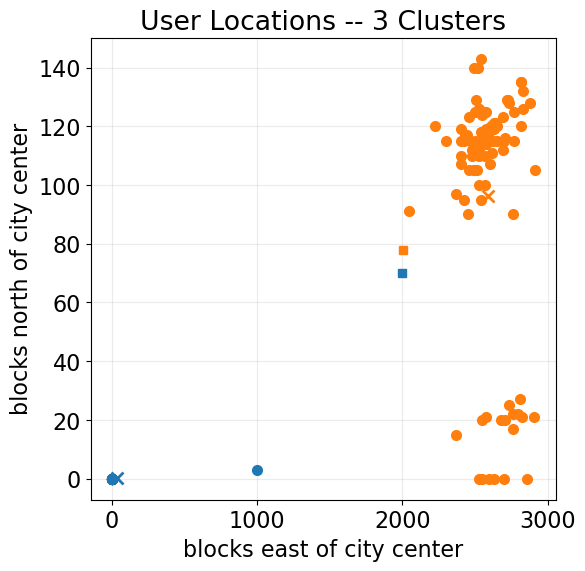

In [109]:
fig, ax = plt.subplots(figsize=(6, 6))


for i in range(len(means)):
  plot_handler = ax.plot(*means[i], marker='x', markeredgewidth=2, markersize=9)
  x_data = [xi for xi, _ in cluster_dict[i]]
  y_data = [yi for _, yi in cluster_dict[i]]

  
  color_kmeans = plot_handler[0]._color
  # print(color_kmeans)
  # plot initial means
  ax.plot(*clusterer.means_init[i], marker='s', color=color_kmeans, 
    )

  ax.plot(x_data, y_data, marker='o', linestyle='None', markersize=7, 
    color=color_kmeans)

ax.set_xlabel("blocks east of city center")
ax.set_ylabel("blocks north of city center")
ax.grid("on")
ax.set_title("User Locations -- 3 Clusters")

plt.show(fig)